In [40]:
import tcrdist as td
import pandas as pd
from tcrdist.repertoire import TCRrep
from tcrdist.proximity import TCRproximity
import numpy as np
import parasail
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
# reading the db file
vdj = pd.read_csv('../vdjdb-dump/vdjdb_a02_4epi_trab_200.txt', sep='\t')
vdj.shape

(1600, 5)

In [3]:
vdj.head()

,gene,cdr3,v.segm,j.segm,antigen.epitope
0,TRA,CAGAGRGNRDDKIIF,TRAV27*01,TRAJ30*01,GILGFVFTL
1,TRA,CAASALRGMDSNYQLIW,TRAV29/DV5*01,TRAJ33*01,GILGFVFTL
2,TRA,CAARGNYGQNFVF,TRAV29/DV5*01,TRAJ26*01,GILGFVFTL
3,TRA,CAVKNNNDMRF,TRAV12-2*01,TRAJ43*01,GILGFVFTL
4,TRA,CAMSDGGGSNYKLTF,TRAV12-3*01,TRAJ53*01,GILGFVFTL


In [4]:
# keeping only human entries and beta chains
# vdj = vdj.loc[(vdj.species == 'HomoSapiens') & (vdj.gene == 'TRB')]
vdj = vdj.loc[(vdj.gene == 'TRB')]

In [5]:
# counting the number of unique TCRs for an epitope
# ge30 = vdj.groupby('antigen.epitope').cdr3.count() >= 30

In [6]:
# removing all epitopes which have less then 30 unique TCRs
# vdj = vdj.loc[(vdj['antigen.epitope'].isin(ge30[ge30].index))]

In [7]:
# finding epitopes with more than 1000 unique TCRs
# ge1000 = vdj.groupby('antigen.epitope').cdr3.count().sort_values() > 1000

In [8]:
# pseudo-sampling of 1000 rows from each group
# yes, it's just keeping top 1000, will change this later
# sampled = vdj.loc[vdj['antigen.epitope'].isin(ge1000.loc[ge1000].index)].groupby('antigen.epitope').head(1000)

In [9]:
# separate df for epitopes which counts are 30 <= x <= 1000
# bw30_1000 = vdj.loc[~vdj['antigen.epitope'].isin(ge1000.loc[ge1000].index)]

In [10]:
# concatenating two dfs
# vdj = pd.concat([sampled, bw30_1000])

In [4]:
vdj.shape

(1600, 5)

In [5]:
# tcrdist has a specific naming format
# our mapping is not in default lib mappers
mapper = {'complex.id': 'complex_id', 'gene': 'gene', 'cdr3': 'cdr3_b_aa', 'v.segm': 'v_b_gene',
          'j.segm': 'j_b_gene', 'species': 'organism', 'mhc.a': 'mhc_b_a', 'mhc.b': 'mhc_b_b', 
          'mhc.class': 'mhc_b_class', 'antigen.epitope': 'epitope', 'antigen.gene': 'epitope_gene',
          'antigen.species': 'epitope_species', 'reference.id': 'reference', 'vdjdb.score': 'score'}

In [6]:
# dropping unnecessary variables (j.start, v.end) - they do not have corresponding names in the lib
vdj.drop(set(vdj.columns) - mapper.keys(), axis=1, inplace=True)

# renaming columns
vdj.rename(mapper=mapper, axis=1, inplace=True)

In [14]:
# removing references to www.10xgenomics.com
# vdj = vdj[~vdj.reference.str.startswith('https://www.10xgenomics.com/resources/applicat')]

In [15]:
# keeping only 100 random rows for now
# vdj = vdj.sample(10000)
# vdj.head()

In [7]:
# these lines are from example 2
tr = TCRrep(cell_df=vdj, organism="human")

In [8]:
# not sure whether this step is OK: need to figure out more about imgt_aligned argument
tr.infer_cdrs_from_v_gene(chain='beta', imgt_aligned=True)  

/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:155: UserWarning: TRAV25*01,TRAV27*01 gene was not recognized in reference db no cdr seq could be inferred
  warnings.warn("{} gene was not recognized in reference db no cdr seq could be inferred".format(gene))
/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:155: UserWarning: TRAV8-2*01,TRAV10*01 gene was not recognized in reference db no cdr seq could be inferred
  warnings.warn("{} gene was not recognized in reference db no cdr seq could be inferred".format(gene))
/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:155: UserWarning: TRAV12-2*01,TRAV13-1*01 gene was not recognized in reference db no cdr seq could be inferred
  warnings.warn("{} gene was not recognized in reference db no cdr seq could be inferred".format(gene))
/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:155: UserWarning: TRAV16*01,TRAV6*01 gene was not recognized in reference db no cdr seq co

In [9]:
# a new attribute after running infer_cdrs_from_v_gene()
tr.cell_df.head()

,gene,cdr3_b_aa,v_b_gene,j_b_gene,epitope,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa
0,TRA,CAGAGRGNRDDKIIF,TRAV27*01,TRAJ30*01,GILGFVFTL,SVF.......SS,VVTG...GEV,GDARKD
1,TRA,CAASALRGMDSNYQLIW,TRAV29/DV5*01,TRAJ33*01,GILGFVFTL,NSM......FDY,ISSI...KDK,NKSAKH
2,TRA,CAARGNYGQNFVF,TRAV29/DV5*01,TRAJ26*01,GILGFVFTL,NSM......FDY,ISSI...KDK,NKSAKH
3,TRA,CAVKNNNDMRF,TRAV12-2*01,TRAJ43*01,GILGFVFTL,DRG......SQS,IYS....NGD,NKASQY
4,TRA,CAMSDGGGSNYKLTF,TRAV12-3*01,TRAJ53*01,GILGFVFTL,NSA......FQY,TYS....SGN,DKSSKY


In [10]:
# these columns will determine duplicates
tr.index_cols = ['epitope', 'cdr3_b_aa', 'cdr1_b_aa', 'cdr2_b_aa', 'pmhc_b_aa', 'v_b_gene', 'j_b_gene']

In [11]:
# this clearly does not work and I need to manualy add a column 'count'
tr.cell_df['count'] = 1
tr.deduplicate()

tcrdist.repertoire.TCRrep for <Your TCR Repertoire Project>
 with index_cols: ['epitope', 'cdr3_b_aa', 'cdr1_b_aa', 'cdr2_b_aa', 'pmhc_b_aa', 'v_b_gene', 'j_b_gene']
 with model organism: human

In [12]:
# computing pairwise distances for beta chains with Needleman–Wunsch algorithm using Blosum62
# this fills such attributes as cdr3_b_aa_pw and also tcrdist (required for the next line)
tr.compute_pairwise_all(chain="beta", metric="nw", processes=4, matrix=parasail.blosum62)

# this fills paired_tcrdist between CDR regions 
tr.compute_paired_tcrdist(store_result=True)

/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:649: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:649: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:649: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/home/a

{'paired_tcrdist': array([[  0., 180., 207., ..., 283., 295., 295.],
        [180.,   0.,  93., ..., 253., 307., 313.],
        [207.,  93.,   0., ..., 322., 308., 330.],
        ...,
        [283., 253., 322., ...,   0., 288.,  78.],
        [295., 307., 308., ..., 288.,   0., 306.],
        [295., 313., 330., ...,  78., 306.,   0.]]),
 'paired_tcrdist_weights': {'cdr1_a_aa_pw': 1,
  'cdr2_a_aa_pw': 1,
  'cdr3_a_aa_pw': 1,
  'pmhc_a_aa_pw': 1,
  'cdr1_b_aa_pw': 1,
  'cdr2_b_aa_pw': 1,
  'cdr3_b_aa_pw': 1,
  'pmhc_b_aa_pw': 1}}

In [13]:
# this is like an object with fields for each epitope prediction
pr = namedtuple("perf", ["observed", "predicted", "dist"])

# a list of epitopes
obsereved = tr.clone_df.epitope.to_list()

# a list with all results
performance = []

# a number of neighbours
k = 160

# for each row in a dataset (keeping an index of the row to exclude it)
for row in tr.clone_df.itertuples(index=True):
    
    # excluding the row from a list of indices for which distances will be obtained
    ind = (row.Index != tr.clone_df.index)                        

    # obtaining the distances from the attribute that was filled earlier by compute_paired_tcrdist()
    # so, we are using distances between CDRs (seems so)
    # paired_tcrdist should be replaced by cdr3_b_aa_pw if compute_pairwise_all() was used
    distances = tr.paired_tcrdist[row.Index, ind] 

    # getting indices of storted distances small to large
    sorted_indices = np.argsort(distances)
    
    # getting epitopes associated with those indices
    # here we first exclude the one we are currently working with
    sorted_epitopes = tr.clone_df.epitope.loc[tr.clone_df.index != row.Index].iloc[sorted_indices].to_list()
    
    # getting distances associated with those neighbours
    sorted_distances =  distances[sorted_indices]
    
    # getting predicted epitopes for k nearest neighbours
    predicted = sorted_epitopes[0:k]
    
    # getting distances for k nearest neighbours
    predicted_distance = sorted_distances[0:k]
    
    # appending the list with results 
    performance.append(pr(obsereved[row.Index], predicted, predicted_distance))
    


In [42]:
# performance[:]

#### 03.03: Kind of a conclusion for TCRdist for now

So, the results of clustering do not look that great at first glance. I am not sure about the alignment that is used: seems like it is not used at all, actually. I have mentioned my doubts in a comment to a cell above with infer_cdrs_from_v_gene() 'imgt_aligned' argument.


The algorithm is: calculate distances between CDRs, cluster them with kind of a LOO approach and score the left out CDR. This gives us an opportunity to observe a true epitope which for this CDR and top k epitopes which correspond to the most similar CDRs.


Currently I can only think of computing accuracy as a share of the correct predictions of epitopes. By 'correct prediction' I mean if the top 1 predicted epitope matched the true one.
In addition it is possible to calculate this accuracy in a different way: calculate a sum of ('true epitope rank' divided by k - the total number of predicted variants).
In my opinion, only individual ROC AUC can be calculated for each TCR. Please explain the idea to me, if I am wrong.

#### 10.03: This is an exploration of built-in methods

/home/alex/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


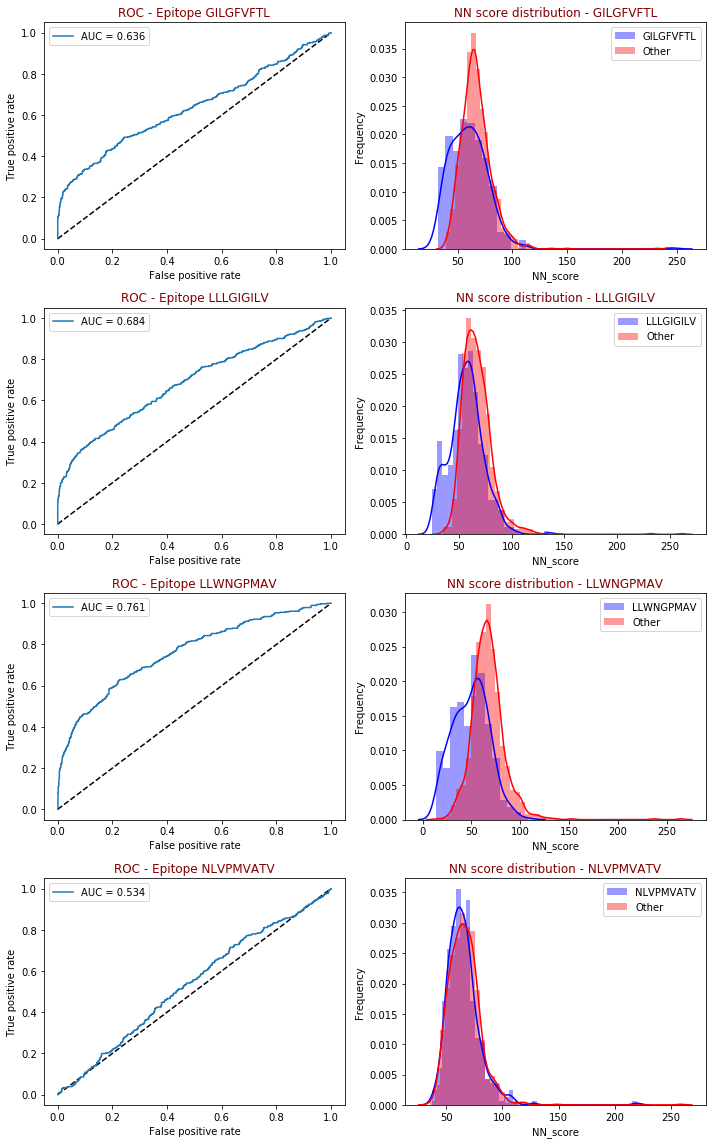

In [49]:
# retrieving unique epitopes
unique_epitopes = tr.clone_df['epitope'].unique()

fig, axs = plt.subplots(len(unique_epitopes), 2, figsize=(10, 16))

# for each unique epitope
for epitope_num, target_epitope in enumerate(unique_epitopes):
    
    # obtaining the rest of epitopes
    other_epitopes = list(set(unique_epitopes) - set(target_epitope))
    
    # using a library class for calculating ROC AUC
    # considering ~top 10% of predicted values
    # only beta chains and CDR3
    # not using cross-validation
    proxy = TCRproximity(tr, target_epitope, other_epitopes, nn_percentile=10, chain='beta', 
                         cdrs='cdr3', subjects_folds=None)
    
    # plotting ROC with AUC
    result = proxy.plot_ROC(ax=axs[epitope_num, 0])
    
    # plotting score distribution
    proxy.plot_NN_score_distribution(ax=axs[epitope_num, 1])
plt.tight_layout()

Seems like that the method does not divide the data properly. The distribution plots show that there is almost no significant difference between the scores of the correctly predicted epitope and the others. 